# Demo book based on data by Monika

## loading a microscopy image

It is all about the iamge format. After a bit of googling I found this to read olympus files in python: https://pypi.org/project/oiffile/#examples

There might be better libs out there

In [1]:
from oiffile import imread

In [2]:
image = imread('../data/100x_A_ckitneg_02.oib')
print(image.shape)
print(image.dtype)

(3, 10, 256, 256)
uint16


Based on the information by Monika the first index is the color channels, and the second index is the z-stack

In [3]:
ch0 = image[0,:,:,:].squeeze()
ch1 = image[1,:,:,:].squeeze()
ch2 = image[2,:,:,:].squeeze()
ch0.shape

(10, 256, 256)

## Exploring our image data

For this purpose I will use stackview, a very cool widget by Robert H.: https://github.com/haesleinhuepf/stackview

In [4]:
import stackview

View the volume slice-by-slice:

In [5]:
stackview.slice(ch0, continuous_update=True)

Get also the orthogonal views

In [6]:
stackview.orthogonal(ch0, continuous_update=True)

Get some basic info about the image

StackViewNDArray([[  19,   22,   28, ...,  584,  656,  737],
                  [  28,   30,   27, ...,  767, 1004, 1166],
                  [  23,   13,   25, ..., 1044, 1337, 1434],
                  ...,
                  [ 107,  100,   83, ...,  196,  294,  424],
                  [  86,  110,  101, ...,  232,  397,  460],
                  [  82,   83,   75, ...,  282,  457,  524]], dtype=uint16)
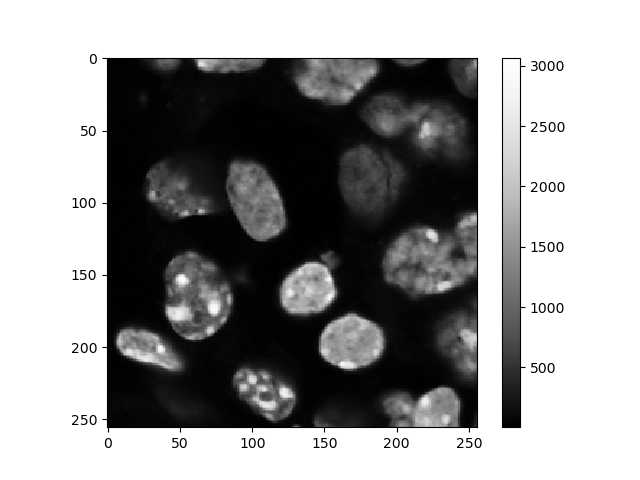
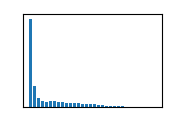

In [7]:
stackview.insight(ch0[5,:,:])

Compare two channels

In [8]:
stackview.side_by_side(ch0* (255/ch0.max()),
                       ch1* (255/ch1.max()), 
                       display_max=255,
                       continuous_update=True, 
                       display_width=300)

You can also view multiple channels with different colormaps at the same time

In [9]:
import numpy as np

StackViewNDArray([[ 19,  12,   8, ..., 278, 199, 139],
                  [  4,  11,  25, ..., 268, 178, 117],
                  [ 16,  20,  16, ..., 233, 161, 124],
                  ...,
                  [ 96,  80,  66, ...,  54,  73,  64],
                  [ 71,  90,  77, ...,  52,  56,  66],
                  [ 93,  89,  78, ...,  64,  92, 116]], dtype=uint16)
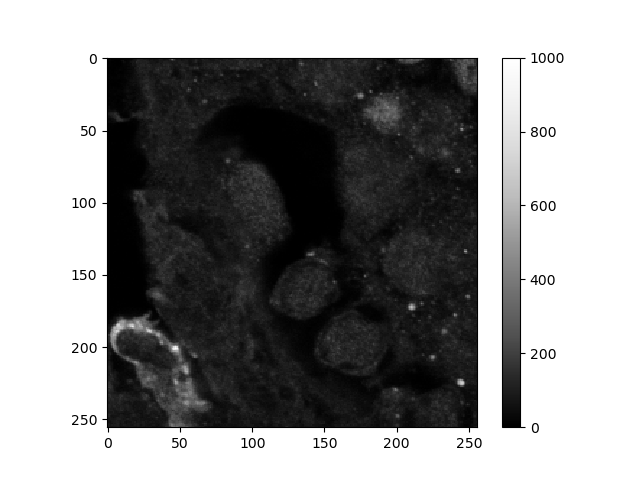
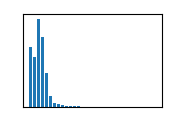

In [10]:
# normalization
z_idx = 5
nuc = ch0[z_idx,:,:].squeeze()
nuc = nuc * (1000/nuc.max())
nuc = nuc.astype(np.uint16)

cyto = ch1[z_idx,:,:].squeeze()
cyto = cyto * (1000/cyto.max())
cyto = cyto.astype(np.uint16)

pbod = ch2[z_idx,:,:].squeeze()
pbod = pbod * (1000/pbod.max())
pbod = pbod.astype(np.uint16)
stackview.insight(pbod)

In [11]:
# toggleable display
stackview.switch(
    {"nucleus":   nuc,
     "cytoplasm": cyto,
     "p bodies":  pbod
    },
    colormap=["pure_blue", "pure_green", "gray"],
    toggleable=True,
    display_max=1000
)

## Image transformations

Some times you might want to make your data isotropic, in terms of resolution, here some basic examples of downscale and rescale

In [12]:
from skimage.transform import downscale_local_mean, rescale

In [13]:
# down_scaling: ds
ds_vol = downscale_local_mean(ch0, (1, 3, 3))
stackview.orthogonal(ds_vol, continuous_update=True)

In [14]:
# up_scaling: us
us_vol = rescale(ch0, (4,1,1), preserve_range=True, anti_aliasing=True).astype(np.uint16)
us_vol.dtype
stackview.orthogonal(us_vol, continuous_update=True)

## Basic processing

I will demos things in 2D but all these steps can be done to 3D volumes also

### Filtering

Let us start with a basic gaussian filter

In [15]:
from skimage.filters import gaussian

im = ch0[5,:,:].squeeze()
im.shape

(256, 256)

In [16]:
s1 = 2
sig_small = gaussian(im,sigma=s1,preserve_range=True)
s2 = np.sqrt(2) * s1
s2 = 20
sig_large = gaussian(im,sigma=s2,preserve_range=True)
dog = sig_small-sig_large

In [17]:
stackview.curtain(im, sig_small, continuous_update=True)

Now we can try Median: edge preserving fiulter

In [18]:
from skimage.filters import median
from skimage.morphology import disk

In [19]:
im_med = median(im, disk(3))

stackview.curtain(im, im_med, continuous_update=True)

A bit more advanced interactive evaluation of parameters

In [20]:
# interactive evaluation of parameters
stackview.interact(median, im)

### Segmentation

We will use a well known method called otsu to find a threshold value automatically

In [21]:
# importing otsu from scikit-image
from skimage.filters import threshold_otsu
from skimage.measure import label

In [22]:
im_med = median(im, disk(3))
th_val = threshold_otsu(im_med)
print('The value is: ', th_val)
bw_otsu = im_med > th_val

stackview.curtain(im, bw_otsu, continuous_update=True)

The value is:  680


### Mophological operations

you can have a look here: https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html

In [23]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects, closing, opening

Fill holes and remove small objects

In [24]:
bw = binary_fill_holes(bw_otsu)
bw = remove_small_objects(bw, min_size=100)
stackview.curtain(im, bw, continuous_update=True)

Morphological closing: https://en.wikipedia.org/wiki/Closing_(morphology)

In [25]:
bw2 = closing(bw, disk(4))
stackview.curtain(bw, bw2+1, continuous_update=True)

Morphological opening: https://en.wikipedia.org/wiki/Opening_(morphology)

In [26]:
bw2 = binary_fill_holes(bw2)
bw3 = opening(bw2,disk(5))
stackview.curtain(bw2, bw3+1, continuous_update=True)

Connected component labeling

In [27]:
lbl = label(bw_otsu)
stackview.curtain(im, lbl, continuous_update=True)

In [28]:
bw = binary_fill_holes(bw_otsu)
bw = remove_small_objects(bw, min_size=100)
bw = closing(bw, disk(4))
bw = binary_fill_holes(bw)

lbl = label(bw)
stackview.curtain(im, lbl, continuous_update=True)

### Basic Quantification


In [29]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd

### Available properties
The list of available properties for ```regionprops``` or ```regionprops_table``` area vailable in this documentation:

https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

API reference -> skimage.mesure -> regionprops -> Notes

In [33]:
cyt_im = ch1[5,:,:].squeeze()
props2get = ['label', 'area', 'eccentricity', 'intensity_mean']

props = regionprops_table(label_image=lbl, intensity_image=cyt_im, properties=props2get)
df = pd.DataFrame(props)
df

,label,area,eccentricity,intensity_mean
0,1,420.0,0.975363,0.000000
1,2,1377.0,0.811099,0.000000
2,3,895.0,0.918043,30.874860
3,4,1513.0,0.818210,213.341705
4,5,632.0,0.886066,0.000000
5,6,2461.0,0.752393,0.000000
6,7,1974.0,0.705320,0.002026
7,8,1161.0,0.610511,0.000000
8,9,1343.0,0.559503,0.000000
9,10,638.0,0.828587,0.017241


In [31]:
th = 20
df2 = df[df['intensity_mean']>th]
df2

,label,area,eccentricity,intensity_mean
2,3,895.0,0.918043,30.874860
3,4,1513.0,0.818210,213.341705


In [32]:
lbl_out = np.zeros_like(lbl)
maxlbl = df['label'].max()

for ind in df.index:
    lbl_idx = df['label'][ind].astype(int)
    if df['intensity_mean'][ind] > th:
        lbl_out[lbl==lbl_idx] = lbl_idx
    else:
        lbl_out[lbl==lbl_idx] = maxlbl+1



stackview.curtain(cyt_im, lbl_out, continuous_update=True)